# Tutorial 2: Neural Likelihood Estimation (NLE)
Credit: Tri Nguyen and Claude Code

In this tutorial, we'll implement neural likelihood estimation (NLE) from scratch using PyTorch. NLE is a simulation-based inference method that uses neural networks to approximate the likelihood function $p(x|\theta)$, which can then be combined with sampling algorithms to obtain the posterior.

**Setup**:
- Parameter: $\theta$ sampled from a prior distribution $p(\theta)$
- Likelihood: $p(x|\theta)$ which we'll learn with a neural network
- Observation: $x \sim p(x|\theta)$
- Posterior: $p(\theta|x) \propto p(x|\theta) p(\theta)$ (obtained via sampling)

**Goal**: Learn the likelihood $p(x|\theta)$ using a neural network $q_\phi(x|\theta)$, then use sampling to obtain the posterior.

**Key Difference from Tutorial 1**: In NPE (Tutorial 1), we directly learned $p(\theta|x)$. In NLE, we learn $p(x|\theta)$, then use **sampling methods** (MCMC or Nested Sampling) to obtain $p(\theta|x) \propto p(x|\theta)p(\theta)$.

In [1]:
# Import libraries
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader

# Install sampling packages if needed
try:
    import emcee
    import dynesty
    print("✓ Sampling packages already installed")
except ImportError:
    print("Installing emcee and dynesty...")
    !pip install emcee dynesty
    import emcee
    import dynesty
    print("✓ Sampling packages installed")

from dynesty import NestedSampler
from dynesty import plotting as dyplot

# Set random seeds for reproducibility
np.random.seed(42)
torch.manual_seed(42)

print("Libraries imported successfully!")

✓ Sampling packages already installed
Libraries imported successfully!


---
# Part 1a: Gaussian Likelihood on Gaussian Data

We'll start with a simple case where the true likelihood is Gaussian.
We'll implement a simple NLE model where the likelihood is approximated using a Gaussian distribution parameterized by a neural network.

## 1. Generate the training data

We'll use the same Gaussian joint distribution from Tutorial 1.

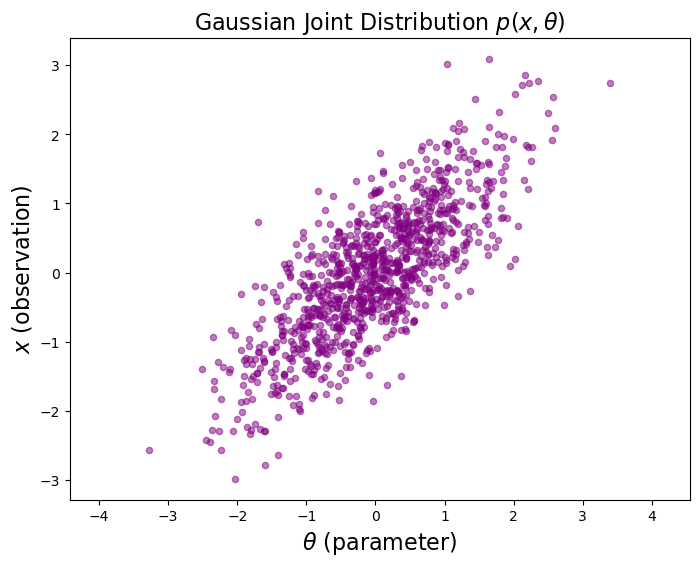

Sampled 1000 points from 2D Gaussian
Correlation between θ and x: 0.780


In [2]:
def sample_gaussian_joint(n_samples, mean=[0, 0], cov=[[1.0, 0.8], [0.8, 1.0]]):
    """
    Sample from a 2D Gaussian joint distribution p(x, θ).

    Parameters:
    - n_samples: number of samples
    - mean: [mean_theta, mean_x]
    - cov: 2x2 covariance matrix

    Returns:
    - theta: parameter values (1D)
    - x: observation values (1D)
    """
    samples = np.random.multivariate_normal(mean, cov, size=n_samples)
    theta = samples[:, 0]
    x = samples[:, 1]
    return theta, x

# Visualize the Gaussian joint distribution
theta_gauss_vis, x_gauss_vis = sample_gaussian_joint(1000)

plt.figure(figsize=(8, 6))
plt.scatter(theta_gauss_vis, x_gauss_vis, alpha=0.5, s=20, color='purple')
plt.xlabel(r'$\theta$ (parameter)', fontsize=16)
plt.ylabel(r'$x$ (observation)', fontsize=16)
plt.title(r'Gaussian Joint Distribution $p(x, \theta)$', fontsize=16)
plt.axis('equal')
plt.show()

print(f"Sampled {len(theta_gauss_vis)} points from 2D Gaussian")
print(f"Correlation between θ and x: {np.corrcoef(theta_gauss_vis, x_gauss_vis)[0,1]:.3f}")

In [3]:
# Generate training data from Gaussian
n_training = 10_000
mean = [0, 0]
cov = [[1.0, 0.8], [0.8, 1.0]]
print(f"Generating {n_training} training samples from Gaussian...")

theta_train_gauss, x_train_gauss = sample_gaussian_joint(n_training, mean=mean, cov=cov)

print(f"✓ Training data generated")
print(f"  θ shape: {theta_train_gauss.shape}")
print(f"  x shape: {x_train_gauss.shape}")

Generating 10000 training samples from Gaussian...
✓ Training data generated
  θ shape: (10000,)
  x shape: (10000,)


## 2. Build Gaussian Likelihood Model

**Recall from Tutorial 1**: We modeled the posterior as $q_\phi(\theta|x) = \mathcal{N}(\theta; \mu_\phi(x), \sigma^2_\phi(x))$, where the input was $x$ and output was parameters for $\theta$.

**In NLE**: We flip this! Now we model the likelihood as $q_\phi(x|\theta) = \mathcal{N}(x; \mu_\phi(\theta), \sigma^2_\phi(\theta))$, where the input is $\theta$ and output is parameters for $x$.

The architecture is identical to Tutorial 1's `GaussianPosterior`, but the roles of $\theta$ and $x$ are swapped.

In [4]:
class GaussianLikelihood(nn.Module):
    """
    Neural network that models p(x|θ) as a Gaussian.

    This architecture is identical to Tutorial 1's GaussianPosterior,
    but here we input θ and output parameters for x.

    Input: θ (parameter)
    Output: mean μ(θ) and std σ(θ) for p(x|θ)
    """

    def __init__(self, hidden_size=64):
        super().__init__()

        self.network = nn.Sequential(
            nn.Linear(1, hidden_size),  # input dimension is 1
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
        )

        # Output layers for mean and log std of Gaussian
        self.mean_layer = nn.Linear(hidden_size, 1)
        self.logstd_layer = nn.Linear(hidden_size, 1)

    def forward(self, theta):
        """Predict Gaussian parameters μ(θ), σ(θ)"""
        features = self.network(theta)
        mean = self.mean_layer(features)
        logstd = self.logstd_layer(features)
        return mean, logstd

    def log_prob(self, x, theta):
        """Compute log p(x|θ)"""
        mean, logstd = self.forward(theta)
        var = torch.exp(2 * logstd)
        log_prob = -0.5 * (np.log(2 * np.pi) + 2 * logstd + ((x - mean) ** 2) / var)
        return log_prob

gaussian_likelihood_v1 = GaussianLikelihood(hidden_size=64)
print("✓ Gaussian likelihood model created")

✓ Gaussian likelihood model created


## 3. Training

The training objective is the same as Tutorial 1. We minimize the negative log-likelihood:

$$\mathcal{L}(\phi) = -\mathbb{E}_{p(x, \theta)}[\log q_\phi(x|\theta)]$$

where $(x, \theta) \sim p(x, \theta)$ are training samples.

In [5]:
def train_likelihood_model(model, theta_train, x_train, epochs=50, batch_size=256, lr=1e-3):
    """
    Train the likelihood model.

    Note: The dataloader order is (theta, x) since we model p(x|θ).
    This is opposite from Tutorial 1 where we had (x, theta) for p(θ|x).
    """
    theta_tensor = torch.tensor(theta_train, dtype=torch.float32).reshape(-1, 1)
    x_tensor = torch.tensor(x_train, dtype=torch.float32).reshape(-1, 1)

    dataset = TensorDataset(theta_tensor, x_tensor)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    losses = []
    print(f"Training for {epochs} epochs...\n")

    for epoch in range(epochs):
        epoch_loss = 0.0
        n_batches = 0

        for theta_batch, x_batch in dataloader:
            optimizer.zero_grad()
            log_prob = model.log_prob(x_batch, theta_batch)
            loss = -log_prob.mean()
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()
            n_batches += 1

        avg_loss = epoch_loss / n_batches
        losses.append(avg_loss)

        if (epoch + 1) % 10 == 0:
            print(f"Epoch {epoch+1:3d}/{epochs} | Loss: {avg_loss:.4f}")

    print("\n✓ Training complete!")
    return losses

# Train on Gaussian data
gauss_lik_losses_v1 = train_likelihood_model(gaussian_likelihood_v1, theta_train_gauss, x_train_gauss, epochs=50)

Training for 50 epochs...

Epoch  10/50 | Loss: 0.8937
Epoch  20/50 | Loss: 0.9050
Epoch  30/50 | Loss: 0.8954
Epoch  40/50 | Loss: 0.8987
Epoch  50/50 | Loss: 0.8983

✓ Training complete!


## 4. Posterior Sampling with MCMC and Nested Sampling

**Key difference from NPE**: In Tutorial 1 (NPE), we could directly sample from $p(\theta|x)$ using the trained model. In NLE, we only have $p(x|\theta)$, so we need to use sampling algorithms to obtain $p(\theta|x) \propto p(x|\theta)p(\theta)$.

We'll implement two sampling approaches:
1. **MCMC with emcee**: Ensemble sampler for exploring the posterior
2. **Nested Sampling with dynesty**: Computes both posterior samples and evidence

In [6]:
def log_likelihood_fn(theta, x_obs, likelihood_model):
    """Log-likelihood function for sampling."""
    theta_tensor = torch.tensor([[theta]], dtype=torch.float32)
    x_tensor = torch.tensor([[x_obs]], dtype=torch.float32)
    with torch.no_grad():
        return likelihood_model.log_prob(x_tensor, theta_tensor).item()

def log_prior_uniform(theta, theta_min=-3, theta_max=3):
    """Uniform prior."""
    if theta_min < theta < theta_max:
        return 0.0  # log(1/(theta_max - theta_min)) + constant
    return -np.inf

def log_posterior_fn(theta, x_obs, likelihood_model, theta_min=-3, theta_max=3):
    """Log-posterior: log p(θ|x) = log p(x|θ) + log p(θ)"""
    lp = log_prior_uniform(theta, theta_min, theta_max)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood_fn(theta, x_obs, likelihood_model)

Define the MCMC and Nested Sampling functions

In [7]:
def sample_with_emcee(likelihood_model, x_obs, n_walkers=32, n_steps=3000,
                      theta_min=-3, theta_max=3, burn_in=1000):
    """
    Sample from posterior using emcee (MCMC).
    """
    ndim = 1

    # Initialize walkers randomly in prior range
    p0 = np.random.uniform(theta_min, theta_max, size=(n_walkers, ndim))

    # Create sampler
    sampler = emcee.EnsembleSampler(
        n_walkers, ndim, log_posterior_fn,
        args=(x_obs, likelihood_model, theta_min, theta_max)
    )

    # Run MCMC
    print(f"  Running emcee with {n_walkers} walkers for {n_steps} steps...")
    sampler.run_mcmc(p0, n_steps, progress=False)

    # Get samples (discard burn-in)
    samples = sampler.get_chain(discard=burn_in, flat=True)

    # Compute acceptance fraction
    acc_frac = np.mean(sampler.acceptance_fraction)
    print(f"  Mean acceptance fraction: {acc_frac:.2%}")

    return samples.flatten()

In [8]:
def prior_transform(u, theta_min=-3, theta_max=3):
    """Transform unit cube to prior (for nested sampling)."""
    return theta_min + (theta_max - theta_min) * u

def sample_with_dynesty(likelihood_model, x_obs, theta_min=-3, theta_max=3,
                       nlive=500, dlogz=0.5):
    """
    Sample from posterior using dynesty (Nested Sampling).
    """
    # Define likelihood for dynesty
    def loglike(theta):
        return log_likelihood_fn(theta[0], x_obs, likelihood_model)

    # Define prior transform
    def ptform(u):
        return np.array([prior_transform(u[0], theta_min, theta_max)])

    # Create nested sampler
    print(f"  Running dynesty with {nlive} live points...")
    sampler = NestedSampler(loglike, ptform, ndim=1, nlive=nlive)
    sampler.run_nested(dlogz=dlogz, print_progress=False)

    results = sampler.results

    # Get weighted posterior samples
    weights = np.exp(results['logwt'] - results['logz'][-1])
    samples = dynesty.utils.resample_equal(results.samples, weights)

    print(f"  Log-evidence: {results.logz[-1]:.2f} ± {results.logzerr[-1]:.2f}")

    return samples.flatten()

## 5. Evaluate: Compare MCMC and Nested Sampling

Let's see how both samplers perform on the Gaussian data.

In [9]:
def plot_posterior_comparison(likelihood_model, x_val, theta_train, x_train,
                              theta_min=-3, theta_max=3):
    """
    Compare MCMC and Nested Sampling for a given x value.

    Similar to Tutorial 1's plot_posterior_comparison, but here we need to
    run sampling algorithms since we have p(x|θ) instead of p(θ|x).
    """
    print(f"\nSampling posterior for x={x_val:.2f}")
    print("=" * 50)

    # MCMC sampling
    print("[1/2] MCMC (emcee):")
    mcmc_samples = sample_with_emcee(likelihood_model, x_val,
                                     theta_min=theta_min, theta_max=theta_max)

    # Nested sampling
    print("\n[2/2] Nested Sampling (dynesty):")
    ns_samples = sample_with_dynesty(likelihood_model, x_val,
                                     theta_min=theta_min, theta_max=theta_max)

    # Plot comparison
    fig, axes = plt.subplots(1, 3, figsize=(15, 4))

    # True posterior (from training data)
    x_margin = 0.15
    mask = np.abs(x_train - x_val) < x_margin
    theta_true = theta_train[mask]

    # MCMC
    axes[0].hist(mcmc_samples, bins=50, density=True, histtype='step',
                label='MCMC', color='C0', lw=4)
    axes[0].hist(theta_true, bins=30, density=True, alpha=0.2,
                color='k', label='True', zorder=0)
    axes[0].set_xlabel(r'$\theta$', fontsize=16)
    axes[0].set_ylabel('Density', fontsize=16)
    axes[0].set_title(f'MCMC: $p(\\theta|x={x_val:.2f})$', fontsize=16)
    axes[0].legend(fontsize=12)
    axes[0].grid(alpha=0.3)

    # Nested Sampling
    axes[1].hist(ns_samples, bins=50, density=True, histtype='step',
                label='Nested Sampling', color='C1', lw=4)
    axes[1].hist(theta_true, bins=30, density=True, alpha=0.2,
                color='k', label='True', zorder=0)
    axes[1].set_xlabel(r'$\theta$', fontsize=16)
    axes[1].set_ylabel('Density', fontsize=16)
    axes[1].set_title(f'Nested Sampling: $p(\\theta|x={x_val:.2f})$', fontsize=16)
    axes[1].legend(fontsize=12)
    axes[1].grid(alpha=0.3)

    # Overlay comparison
    axes[2].hist(mcmc_samples, bins=50, density=True, alpha=0.8,
                label='MCMC', color='C0', histtype='step', lw=4)
    axes[2].hist(ns_samples, bins=50, density=True, alpha=0.8,
                label='Nested Sampling', color='C1', histtype='step', lw=4)
    axes[2].hist(theta_true, bins=30, density=True, alpha=0.2,
                color='k', label='True', zorder=0)
    axes[2].set_xlabel(r'$\theta$', fontsize=16)
    axes[2].set_ylabel('Density', fontsize=16)
    axes[2].set_title('Comparison', fontsize=16)
    axes[2].legend(fontsize=12)
    axes[2].grid(alpha=0.3)

    plt.tight_layout()
    plt.show()

    return mcmc_samples, ns_samples


Sampling posterior for x=0.50
[1/2] MCMC (emcee):
  Running emcee with 32 walkers for 3000 steps...


/tmp/ipykernel_34029/4109779437.py:3: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /pytorch/torch/csrc/utils/tensor_new.cpp:253.)
  theta_tensor = torch.tensor([[theta]], dtype=torch.float32)


  Mean acceptance fraction: 80.73%

[2/2] Nested Sampling (dynesty):
  Running dynesty with 500 live points...
  Log-evidence: -1.57 ± 0.08


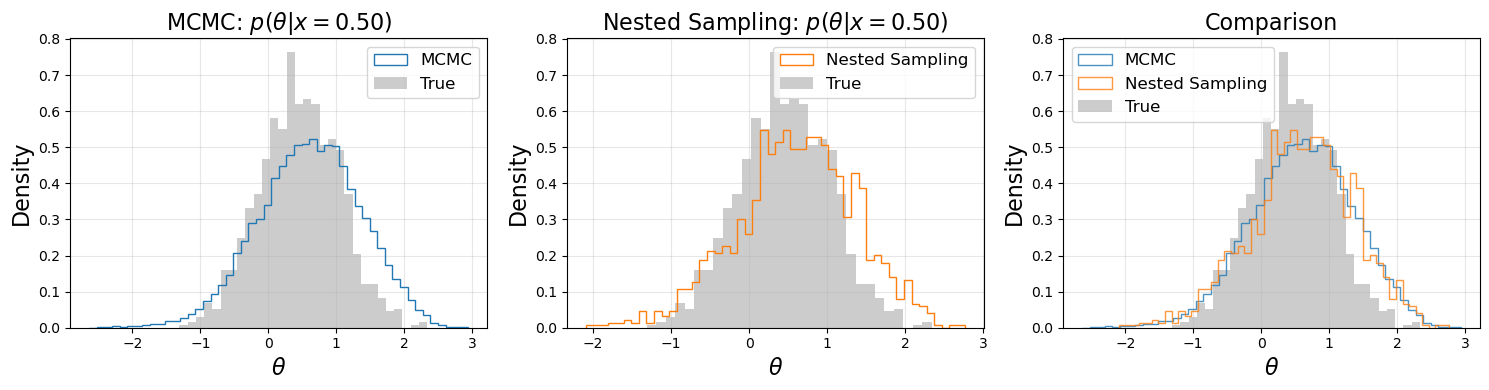

In [10]:
# Test on Gaussian data
test_x = 0.5
mcmc_gauss, ns_gauss = plot_posterior_comparison(
    gaussian_likelihood_v1, test_x, theta_train_gauss, x_train_gauss)

---
# Part 1b: Gaussian Likelihood on Half-Moon Data

Now let's see what happens when we apply the **same Gaussian likelihood** to **non-Gaussian** data! We'll use the half-moon shaped $p(x, \theta)$ from Tutorial 1.

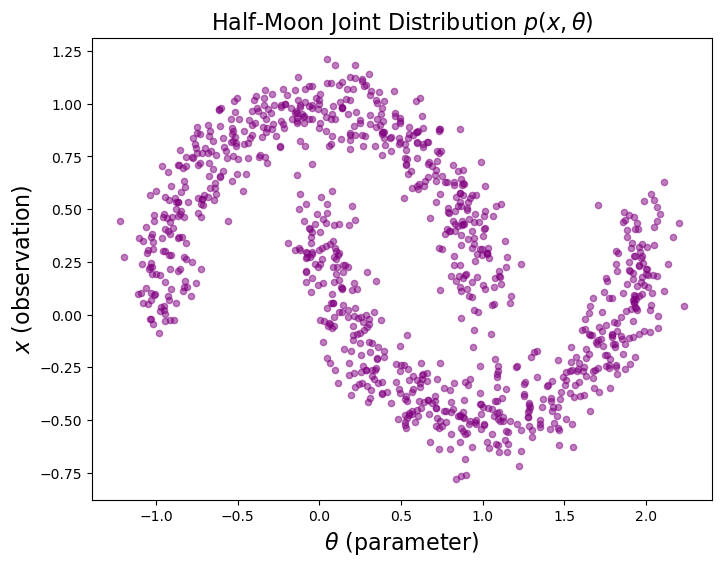

Sampled 1000 points from half-moon
θ range: [-1.22, 2.23]
x range: [-0.78, 1.21]


In [11]:
def sample_halfmoon_joint(n_samples, noise=0.1):
    """
    Sample from half-moon joint distribution p(x, θ).

    Same data generator as Tutorial 1.

    Returns:
    - theta: parameter values (1D)
    - x: observation values (1D)
    """
    samples, labels = make_moons(n_samples=n_samples, noise=noise, random_state=None)
    theta = samples[:, 0]  # First dimension
    x = samples[:, 1]      # Second dimension
    return theta, x

# Visualize
theta_moon_vis, x_moon_vis = sample_halfmoon_joint(1000)

plt.figure(figsize=(8, 6))
plt.scatter(theta_moon_vis, x_moon_vis, alpha=0.5, s=20, color='purple')
plt.xlabel(r'$\theta$ (parameter)', fontsize=16)
plt.ylabel(r'$x$ (observation)', fontsize=16)
plt.title(r'Half-Moon Joint Distribution $p(x, \theta)$', fontsize=16)
plt.show()

print(f"Sampled {len(theta_moon_vis)} points from half-moon")
print(f"θ range: [{theta_moon_vis.min():.2f}, {theta_moon_vis.max():.2f}]")
print(f"x range: [{x_moon_vis.min():.2f}, {x_moon_vis.max():.2f}]")

In [12]:
# Generate training data from half-moon
n_training = 10_000
print(f"Generating {n_training} training samples from half-moon...")

theta_train_moon, x_train_moon = sample_halfmoon_joint(n_training, noise=0.1)

print(f"✓ Training data generated")
print(f"  θ shape: {theta_train_moon.shape}")
print(f"  x shape: {x_train_moon.shape}")

# Train Gaussian likelihood on half-moon
gaussian_likelihood_v2 = GaussianLikelihood(hidden_size=64)
print("\nTraining Gaussian likelihood on half-moon data...")
gauss_lik_losses_v2 = train_likelihood_model(gaussian_likelihood_v2, theta_train_moon, x_train_moon, epochs=50)

Generating 10000 training samples from half-moon...
✓ Training data generated
  θ shape: (10000,)
  x shape: (10000,)

Training Gaussian likelihood on half-moon data...
Training for 50 epochs...

Epoch  10/50 | Loss: 0.2814
Epoch  20/50 | Loss: 0.2349
Epoch  30/50 | Loss: 0.2224
Epoch  40/50 | Loss: 0.2166
Epoch  50/50 | Loss: 0.2136

✓ Training complete!


## 6. Evaluate: Gaussian Likelihood on Half-Moon

Let's see how the Gaussian likelihood performs with sampling on non-Gaussian data. Just like in Tutorial 1, we expect the Gaussian model to struggle here.


Sampling posterior for x=0.50
[1/2] MCMC (emcee):
  Running emcee with 32 walkers for 3000 steps...
  Mean acceptance fraction: 52.11%

[2/2] Nested Sampling (dynesty):
  Running dynesty with 500 live points...
  Log-evidence: -0.41 ± 0.08


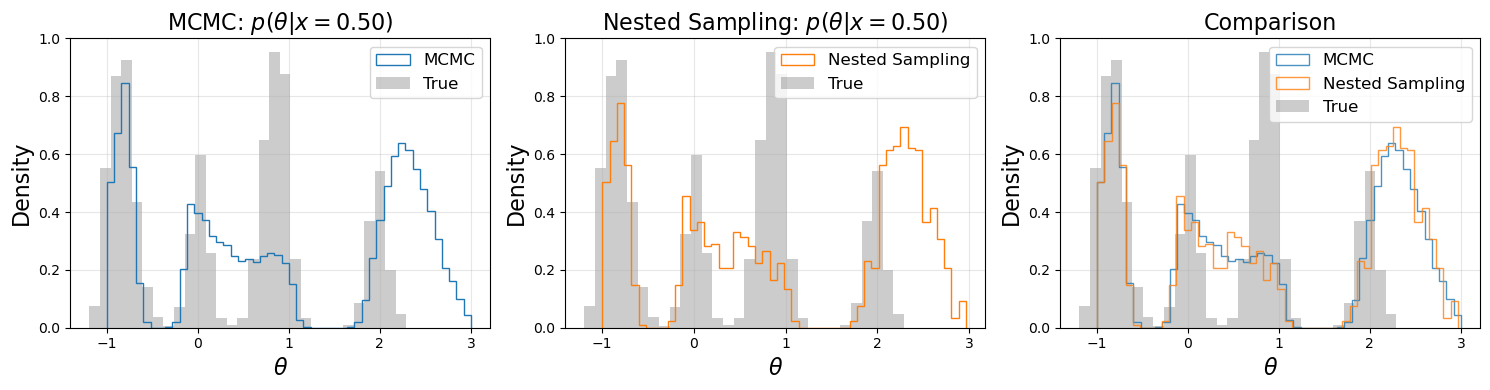

In [13]:
# Test on half-moon data
test_x_moon = 0.5
mcmc_moon_gauss, ns_moon_gauss = plot_posterior_comparison(
    gaussian_likelihood_v2, test_x_moon, theta_train_moon, x_train_moon,
    theta_min=-1, theta_max=3)

In this case, the prior distribution $p(\theta)$ extends beyond the range of the training data. If the model does not learn the correct likelihood in these regions (as we have seen in this case), the posterior estimates will be poor. 

In practice, one should ensure that the prior distribution is well-aligned with the training data to avoid such issues.

---
# Part 2: Flow-based Likelihood

Since the Gaussian likelihood **failed** on the half-moon data (just like in Tutorial 1), we need a more flexible likelihood model. We'll use normalizing flows!

**Recall from Tutorial 1**: Flows learn an invertible transformation $\theta = T(z; x)$ where $z \sim \mathcal{N}(0, 1)$ to model complex posteriors $p(\theta|x)$.

**In NLE**: We do the same thing, but flipped! We model $x = T(z; \theta)$ to learn the likelihood $p(x|\theta)$. Same flexible architecture, just swapped roles.

In [14]:
# Install zuko
try:
    import zuko
    print("✓ zuko already installed")
except ImportError:
    print("Installing zuko...")
    !pip install zuko
    import zuko

from zuko.flows import NSF

✓ zuko already installed


In [15]:
class FlowLikelihood(nn.Module):
    """
    Flow-based model for p(x|θ) using Neural Spline Flows.

    This architecture is identical to Tutorial 1's FlowPosterior,
    but here we input θ (as context) and model the distribution over x.
    """

    def __init__(self, hidden_size=64, embedding_size=8, transforms=5):
        super().__init__()

        # Embed θ before passing to the flow
        self.embedding_network = nn.Sequential(
            nn.Linear(1, hidden_size),  # input dimension is 1 (θ)
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, embedding_size),
        )

        # NSF: Neural Spline Flow
        # models x conditioned on embedded θ
        self.flow = NSF(
            features=1,                 # dimension of x
            context=embedding_size,     # dimension of embedded θ
            transforms=transforms,      # number of transformations
            hidden_features=[hidden_size, hidden_size],
        )

    def forward(self, theta):
        """Return the flow conditioned on θ"""
        theta_embedded = self.embedding_network(theta)
        return self.flow(theta_embedded)

    def log_prob(self, x, theta):
        """Compute log p(x|θ)"""
        theta_embedded = self.embedding_network(theta)
        return self.flow(theta_embedded).log_prob(x)

flow_likelihood = FlowLikelihood(hidden_size=64, embedding_size=8, transforms=5)
print("✓ Flow-based likelihood model created")

✓ Flow-based likelihood model created


In [16]:
# Train flow likelihood on half-moon data
print("Training flow likelihood on half-moon data...")
flow_lik_losses = train_likelihood_model(flow_likelihood, theta_train_moon, x_train_moon, epochs=50)

Training flow likelihood on half-moon data...
Training for 50 epochs...

Epoch  10/50 | Loss: -0.0609
Epoch  20/50 | Loss: -0.0978
Epoch  30/50 | Loss: -0.0884
Epoch  40/50 | Loss: -0.0913
Epoch  50/50 | Loss: -0.0813

✓ Training complete!


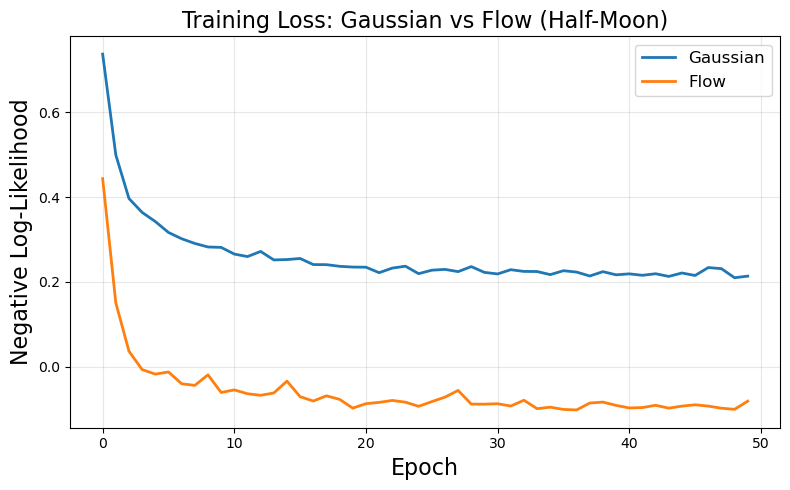

Final loss - Gaussian: 0.2136
Final loss - Flow: -0.0813
Improvement: 0.2949


In [17]:
# Compare losses: Gaussian vs Flow
fig, ax = plt.subplots(figsize=(8, 5))
ax.plot(gauss_lik_losses_v2, linewidth=2, label='Gaussian')
ax.plot(flow_lik_losses, linewidth=2, label='Flow')
ax.set_xlabel('Epoch', fontsize=16)
ax.set_ylabel('Negative Log-Likelihood', fontsize=16)
ax.set_title('Training Loss: Gaussian vs Flow (Half-Moon)', fontsize=16)
ax.legend(fontsize=12)
ax.grid(alpha=0.3)
plt.tight_layout()
plt.show()

print(f"Final loss - Gaussian: {gauss_lik_losses_v2[-1]:.4f}")
print(f"Final loss - Flow: {flow_lik_losses[-1]:.4f}")
print(f"Improvement: {gauss_lik_losses_v2[-1] - flow_lik_losses[-1]:.4f}")

## 7. Evaluate: Flow Likelihood on Half-Moon

The flow should capture the complex likelihood much better! Let's test with both MCMC and Nested Sampling.


Sampling posterior for x=0.50
[1/2] MCMC (emcee):
  Running emcee with 32 walkers for 3000 steps...
  Mean acceptance fraction: 59.12%

[2/2] Nested Sampling (dynesty):
  Running dynesty with 500 live points...
  Log-evidence: 0.40 ± 0.09


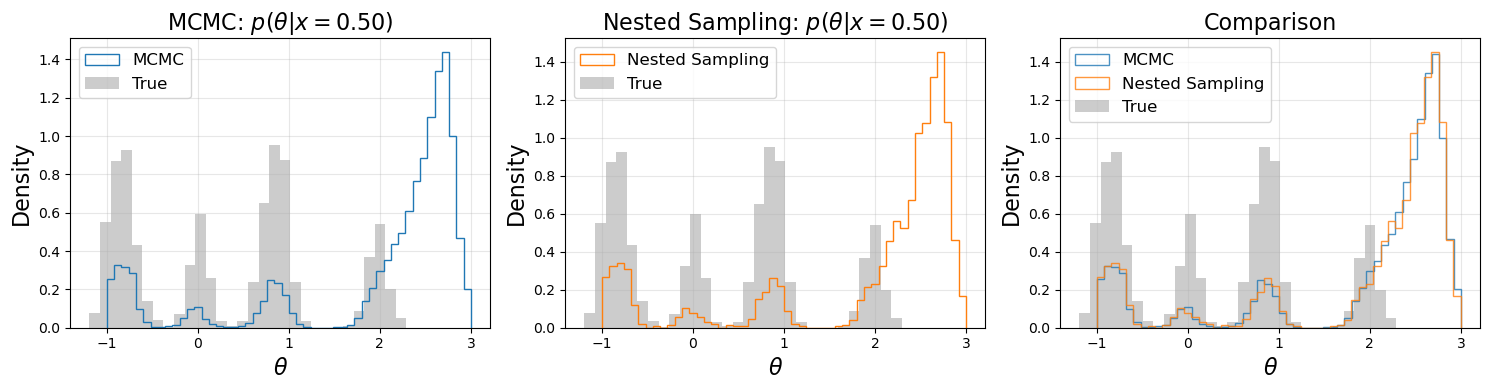

In [18]:
# Test flow likelihood with both samplers
test_x_moon = 0.5
mcmc_moon_flow, ns_moon_flow = plot_posterior_comparison(
    flow_likelihood, test_x_moon, theta_train_moon, x_train_moon,
    theta_min=-1, theta_max=3)

The flow-based likelihood yields better posterior estimates on the half-moon data compared to the Gaussian likelihood. However, as seen before, because the prior extends beyond the training data, the posterior estimates can still be poor in those regions.

## 8. Test Multiple Observations

Let's test the flow likelihood on multiple x values to see the pattern across different observations.


Testing x = -0.30

Sampling posterior for x=-0.30
[1/2] MCMC (emcee):
  Running emcee with 32 walkers for 3000 steps...
  Mean acceptance fraction: 65.24%

[2/2] Nested Sampling (dynesty):
  Running dynesty with 500 live points...
  Log-evidence: -0.76 ± 0.10


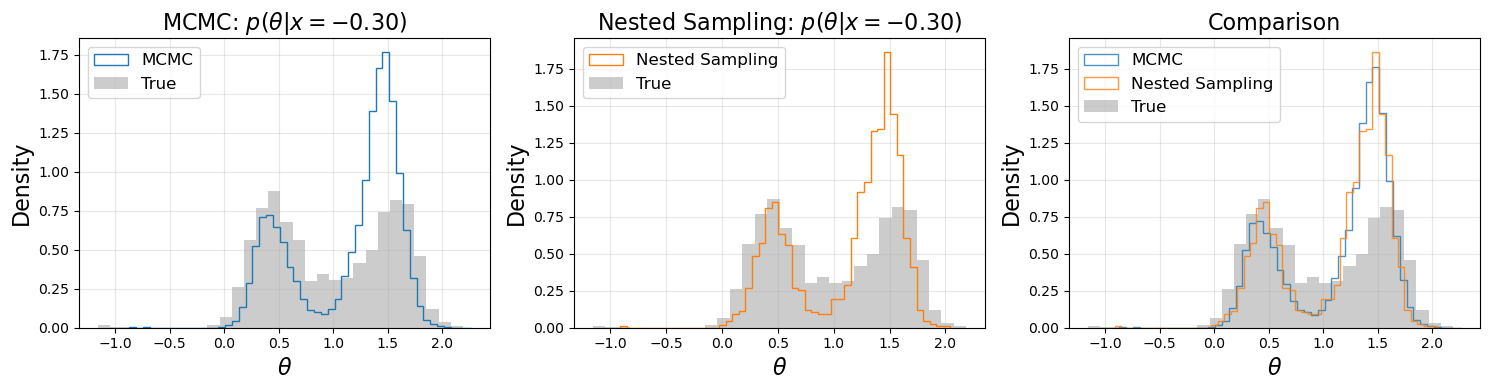


Testing x = 0.00

Sampling posterior for x=0.00
[1/2] MCMC (emcee):
  Running emcee with 32 walkers for 3000 steps...
  Mean acceptance fraction: 50.71%

[2/2] Nested Sampling (dynesty):
  Running dynesty with 500 live points...
  Log-evidence: -1.08 ± 0.09


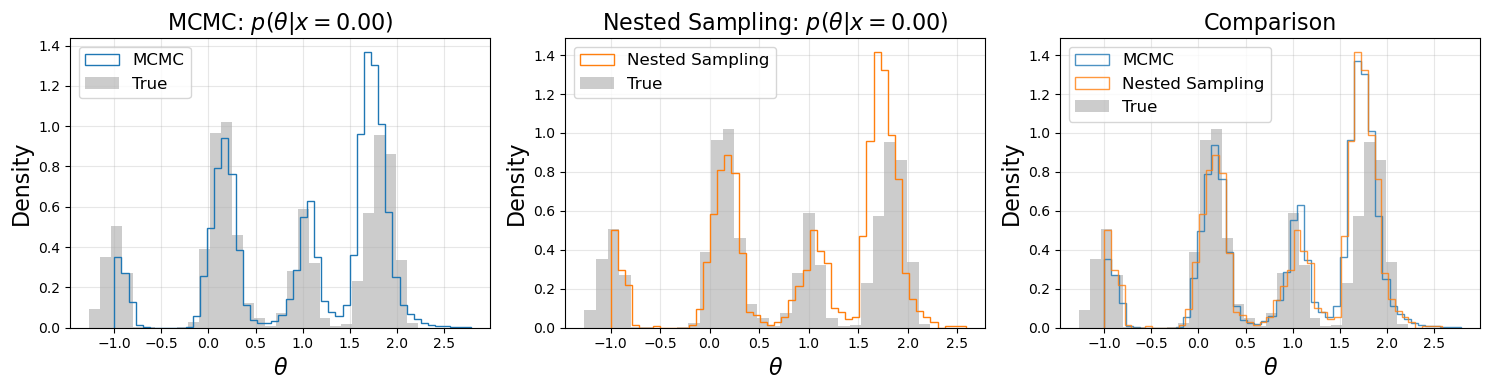


Testing x = 0.30

Sampling posterior for x=0.30
[1/2] MCMC (emcee):
  Running emcee with 32 walkers for 3000 steps...
  Mean acceptance fraction: 47.41%

[2/2] Nested Sampling (dynesty):
  Running dynesty with 500 live points...
  Log-evidence: -0.57 ± 0.09


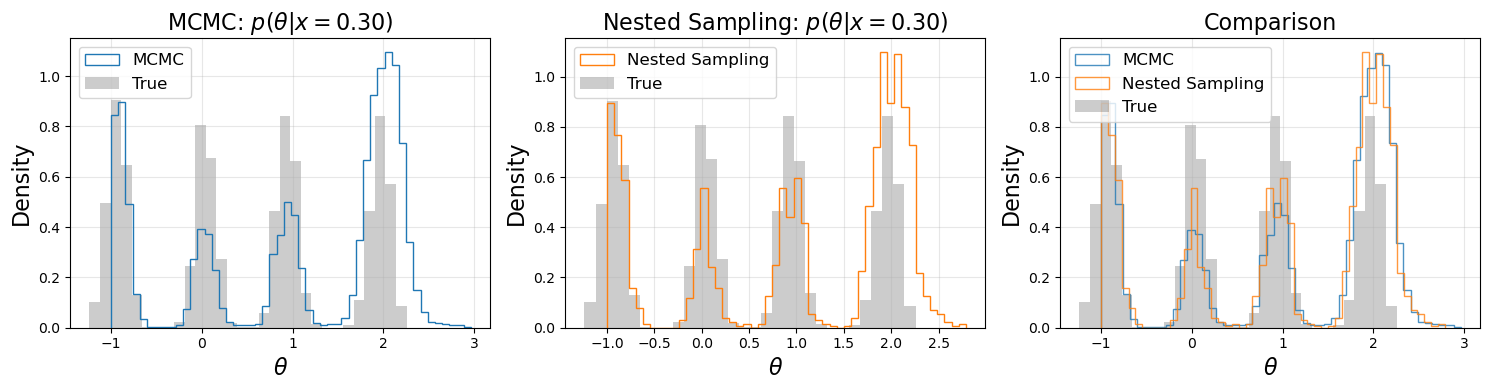


Testing x = 0.80

Sampling posterior for x=0.80
[1/2] MCMC (emcee):
  Running emcee with 32 walkers for 3000 steps...
  Mean acceptance fraction: 62.25%

[2/2] Nested Sampling (dynesty):
  Running dynesty with 500 live points...
  Log-evidence: -0.50 ± 0.10


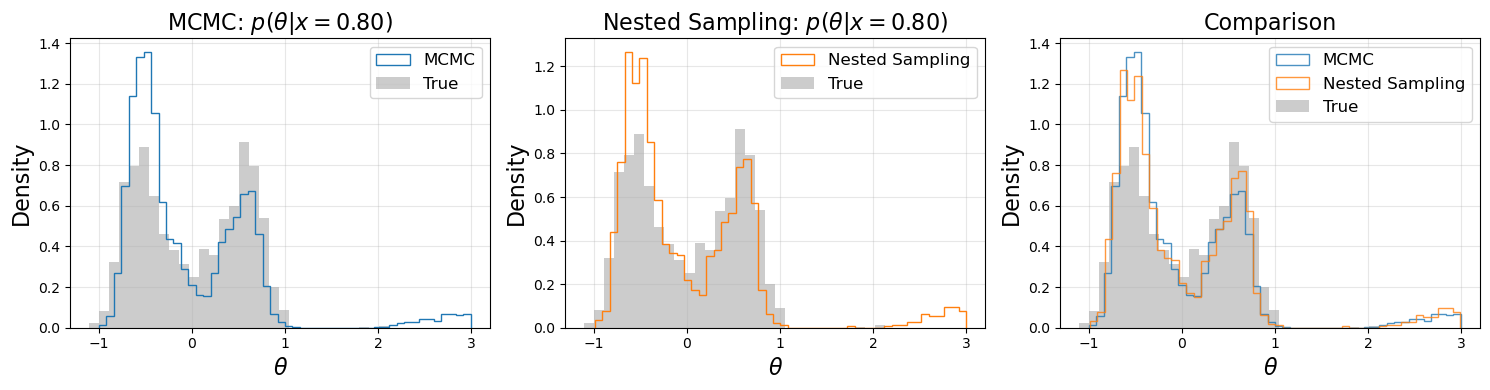

In [19]:
# Test on multiple x values
for x_test in [-0.3, 0.0, 0.3, 0.8]:
    print("\n" + "="*70)
    print(f"Testing x = {x_test:.2f}")
    print("="*70)
    mcmc, ns = plot_posterior_comparison(
        flow_likelihood, x_test, theta_train_moon, x_train_moon,
        theta_min=-1, theta_max=3)

---
## Summary

In this tutorial, we explored NLE with two different sampling methods and demonstrated why normalizing flows have become the standard method for likelihood modeling.

### What We Demonstrated

**Part 1a: Gaussian Likelihood on Gaussian Data**
- Modeled $p(x|\theta) = \mathcal{N}(x; \mu(\theta), \sigma^2(\theta))$ using a simple neural network
- Worked well because the true likelihood was Gaussian
- Both MCMC and Nested Sampling recovered accurate posteriors

**Part 1b: Gaussian Likelihood on Half-Moon Data**
- Applied the same Gaussian model to non-Gaussian data
- **Failed** to capture the complex curved structure (same failure as Tutorial 1)
- Sampling algorithms still work, but produce incorrect posteriors due to the misspecified likelihood

**Part 2: Flow-based Likelihood**
- Used normalizing flows (Neural Spline Flows) to model $p(x|\theta)$
- Successfully captured the half-moon structure
- Significantly lower training loss (showing better fit)
- Both MCMC and Nested Sampling produce accurate posterior samples

### Key Differences: NPE (Tutorial 1) vs NLE (Tutorial 2)

| Aspect | NPE (Tutorial 1) | NLE (Tutorial 2) |
|--------|------------------|------------------|
| **What we learn** | $p(\theta\|x)$ directly | $p(x\|\theta)$ |
| **Inference** | Direct sampling from model | Requires MCMC/Nested Sampling |
| **Flexibility** | Posterior must be representable by model | Any posterior shape (via sampling) |
| **Speed** | Fast (direct sampling) | Slower (need sampling) |
| **Model architecture** | Input: $x$, Output: $\theta$ | Input: $\theta$, Output: $x$ |

### Key Takeaway

**For NLE applications, use normalizing flows for the likelihood.**

The benefits mirror Tutorial 1's findings:
- **Flexibility**: Can represent arbitrary likelihood distributions
- **Reliability**: Work well even when likelihood structure is unknown  
- **Standard practice**: The de facto choice in modern simulation-based inference

### Choosing Between Sampling Methods

- **MCMC (emcee)**: Fast and efficient for simple, unimodal posteriors
- **Nested Sampling (dynesty)**: More robust for multimodal/complex posteriors, also provides evidence estimates

### When to Use NLE vs NPE?

- **Use NPE (Tutorial 1)** when you want fast inference and can afford flexible posterior models
- **Use NLE (Tutorial 2)** when the likelihood is more natural to model, or when you need evidence estimates from nested sampling

In practice, **NPE is often preferred** because direct posterior sampling is faster. However, NLE remains important for cases where likelihood modeling is more intuitive or when you need the flexibility of choosing different sampling algorithms.